# Tournament Modeling 2003-2019
This notebook is where the modeling will take place. The first stage in the modeling will be using end of season metrics from the 2003-2014 seasons to predict 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
import os
import json
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
sys.path.append("/Users/atticussoane/Desktop/atticus_tools/")
from recursive_selection import FeatureSelector

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
if not os.path.exists("./models/"):
    os.makedirs("./models/")

In [3]:
pd.set_option('max.columns', 100)
tourney_df = pd.read_csv("./engineered_data/tournament_modeling2003-2019.csv.gz", compression = "gzip")
tourney_df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WseedN,WDRB_DIF,WORB_DIF,WPPG,WPPP,WTRB_DIF,Wast_TO,We_fg,Wfg,Wfree_throw_pct,Wopp_PPG,Wopp_PPP,Wopp_ast_TO,Wopp_efg,Wopp_fg,Wopp_three_point_pct,Wopp_trueshooting,Wthree_point_pct,Wtotal_point_differential,Wtrue_shooting,Wacc,Wbig_east,Wbig_ten,Wbig_twelve,Wsec,Wpac12,WMOR,WAP_top10,WAP_top25,LseedN,LDRB_DIF,LORB_DIF,LPPG,LPPP,LTRB_DIF,Last_TO,Le_fg,Lfg,Lfree_throw_pct,Lopp_PPG,Lopp_PPP,Lopp_ast_TO,Lopp_efg,Lopp_fg,Lopp_three_point_pct,Lopp_trueshooting,Lthree_point_pct,Ltotal_point_differential,Ltrue_shooting,Lacc,Lbig_east,Lbig_ten,Lbig_twelve,Lsec,Lpac12,LMOR,LAP_top10,LAP_top25
0,2003,134,1421,92,1411,84,16,10,-42,71.206897,0.866162,-32,0.804255,0.486339,0.429265,0.762768,78.448276,0.937078,1.236559,0.518382,0.455882,0.367110,0.553323,0.360153,-210,0.539424,0,0,0,0,0,0,277.0,0,0,16,58,37,72.800000,0.878704,95,0.932166,0.501206,0.447527,0.619952,70.833333,0.853660,0.960465,0.487307,0.424945,0.325180,0.515957,0.320721,59,0.538334,0,0,0,0,0,0,293.0,0,0
1,2003,136,1112,80,1436,51,1,122,58,85.214286,0.931304,180,1.193237,0.514946,0.461413,0.701429,70.250000,0.786410,0.917373,0.456378,0.407510,0.316637,0.484664,0.350534,419,0.555400,0,0,0,0,0,1,4.0,1,0,16,112,98,67.793103,0.863235,210,1.009804,0.491667,0.444444,0.657848,63.137931,0.841808,1.021220,0.477458,0.413275,0.329582,0.509154,0.340757,135,0.525815,0,0,0,0,0,0,187.0,0,0
2,2003,136,1113,84,1272,71,10,80,78,75.965517,0.921603,158,1.110837,0.513333,0.478182,0.669737,69.172414,0.862499,0.906667,0.494424,0.445477,0.342733,0.534705,0.317808,197,0.555080,0,0,0,0,0,1,22.0,0,0,7,69,50,74.517241,0.888511,119,1.205000,0.496264,0.437931,0.653614,65.827586,0.802290,0.883295,0.453218,0.402265,0.322034,0.491392,0.348797,252,0.531700,0,0,0,0,0,0,23.0,0,1
3,2003,136,1141,79,1166,73,11,127,-48,79.344828,0.967538,79,0.856333,0.570026,0.505236,0.765753,73.241379,0.875414,0.733906,0.497619,0.454762,0.357320,0.541759,0.380769,177,0.622161,0,0,0,0,0,0,50.0,0,0,6,60,-6,79.242424,0.995114,54,1.258503,0.568829,0.499473,0.692890,64.333333,0.806783,0.724689,0.475630,0.431544,0.341102,0.513189,0.389053,492,0.597895,0,0,0,0,0,0,33.0,0,1
4,2003,136,1143,76,1301,74,8,40,2,74.482759,0.914077,42,1.128954,0.520258,0.465649,0.685512,69.758621,0.856971,1.073903,0.492082,0.431672,0.331190,0.524735,0.376518,137,0.553267,0,0,0,0,0,1,43.0,0,0,9,18,-24,72.400000,0.945927,-6,1.032864,0.530937,0.456250,0.770358,68.000000,0.882032,0.858770,0.494981,0.441029,0.337255,0.544337,0.354074,132,0.580699,1,0,0,0,0,0,31.0,0,0


Right off the bat there is a problem with the way the data is structured. The dataframe is split into winning and losing teams, so creating a binary win/lose variable with the current set up would result in all 1s. Obviously this is not what we want, so there are two solutions that I see:

$\cdot$ Split the dataframe into two halves (alternating rows) and flip the winning and losing team stats, instead calling them team1 and team2. This will create a perfectly balanced target binary class.

$\cdot$ Leave the dataframe how it is, and instead create a binary feature of whether not a higher seeded team beat a lower seeded team; making a model that predicts upsets. 

The upset model is not the name of the game (although I'm going to do that anyway). The contest is about predicting win probabilities, so I will start with that method. I'm going to split the DataFrame perfectly in half. My concern with using a random split (like KFold splitter something of that nature) is that since we are using past seasons to model future seasons, there is a possibility that an entire season may end up with only one target class. The safest course is to create two perfectly balanced target classes.

In [4]:
print(len(tourney_df))

1115


In [5]:
def all_even(n):
    even_indices = []
    i = 0
    while 2 * i < n:
        even_indices.append(2 * i)
        i += 1
    return(even_indices)

even_indices = all_even(1115)
even_df = tourney_df.iloc[even_indices].reset_index(drop = True)
odd_df = tourney_df.drop(even_indices, axis = 0).reset_index(drop = True)

In [6]:
len(even_df), len(odd_df)

(558, 557)

In [7]:
even_df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WseedN,WDRB_DIF,WORB_DIF,WPPG,WPPP,WTRB_DIF,Wast_TO,We_fg,Wfg,Wfree_throw_pct,Wopp_PPG,Wopp_PPP,Wopp_ast_TO,Wopp_efg,Wopp_fg,Wopp_three_point_pct,Wopp_trueshooting,Wthree_point_pct,Wtotal_point_differential,Wtrue_shooting,Wacc,Wbig_east,Wbig_ten,Wbig_twelve,Wsec,Wpac12,WMOR,WAP_top10,WAP_top25,LseedN,LDRB_DIF,LORB_DIF,LPPG,LPPP,LTRB_DIF,Last_TO,Le_fg,Lfg,Lfree_throw_pct,Lopp_PPG,Lopp_PPP,Lopp_ast_TO,Lopp_efg,Lopp_fg,Lopp_three_point_pct,Lopp_trueshooting,Lthree_point_pct,Ltotal_point_differential,Ltrue_shooting,Lacc,Lbig_east,Lbig_ten,Lbig_twelve,Lsec,Lpac12,LMOR,LAP_top10,LAP_top25
0,2003,134,1421,92,1411,84,16,10,-42,71.206897,0.866162,-32,0.804255,0.486339,0.429265,0.762768,78.448276,0.937078,1.236559,0.518382,0.455882,0.367110,0.553323,0.360153,-210,0.539424,0,0,0,0,0,0,277.0,0,0,16,58,37,72.800000,0.878704,95,0.932166,0.501206,0.447527,0.619952,70.833333,0.853660,0.960465,0.487307,0.424945,0.325180,0.515957,0.320721,59,0.538334,0,0,0,0,0,0,293.0,0,0
1,2003,136,1113,84,1272,71,10,80,78,75.965517,0.921603,158,1.110837,0.513333,0.478182,0.669737,69.172414,0.862499,0.906667,0.494424,0.445477,0.342733,0.534705,0.317808,197,0.555080,0,0,0,0,0,1,22.0,0,0,7,69,50,74.517241,0.888511,119,1.205000,0.496264,0.437931,0.653614,65.827586,0.802290,0.883295,0.453218,0.402265,0.322034,0.491392,0.348797,252,0.531700,0,0,0,0,0,0,23.0,0,1
2,2003,136,1143,76,1301,74,8,40,2,74.482759,0.914077,42,1.128954,0.520258,0.465649,0.685512,69.758621,0.856971,1.073903,0.492082,0.431672,0.331190,0.524735,0.376518,137,0.553267,0,0,0,0,0,1,43.0,0,0,9,18,-24,72.400000,0.945927,-6,1.032864,0.530937,0.456250,0.770358,68.000000,0.882032,0.858770,0.494981,0.441029,0.337255,0.544337,0.354074,132,0.580699,1,0,0,0,0,0,31.0,0,0
3,2003,136,1181,67,1161,57,3,14,47,81.966667,0.945231,61,0.985748,0.514365,0.453591,0.709026,70.400000,0.831509,0.691589,0.481633,0.438484,0.341014,0.526694,0.355987,347,0.563867,1,0,0,0,0,0,10.0,1,0,14,132,-36,74.000000,0.937769,96,0.960744,0.547025,0.506718,0.700549,72.666667,0.913740,1.081744,0.498550,0.449536,0.344898,0.539925,0.363112,40,0.589385,0,0,0,0,0,0,85.0,0,0
4,2003,136,1228,65,1443,60,4,126,-42,75.433333,0.974960,84,1.387342,0.552270,0.485663,0.722513,61.400000,0.784738,0.743820,0.428792,0.376079,0.298429,0.484156,0.368595,421,0.587450,0,0,1,0,0,0,5.0,0,1,13,51,25,73.096774,0.909762,76,0.936170,0.528852,0.459896,0.662080,66.419355,0.829079,0.762295,0.475216,0.434006,0.296680,0.515916,0.366564,207,0.560680,0,0,0,0,0,0,59.0,0,0


In [8]:
even_columns = list(even_df.columns)
for i in range(len(even_columns)):
    if even_columns[i][0] == "W":
        even_columns[i] = even_columns[i].replace("W", "team1_", 1)
    elif even_columns[i][0] == "L":
        even_columns[i] = even_columns[i].replace("L", "team2_", 1)

odd_columns = list(odd_df.columns)
for i in range(len(odd_columns)):
    if odd_columns[i][0] == "W":
        odd_columns[i] = odd_columns[i].replace("W", "team2_", 1)
    elif odd_columns[i][0] == "L":
        odd_columns[i] = odd_columns[i].replace("L", "team1_", 1)

In [9]:
even_df.columns = even_columns
odd_df.columns = odd_columns

even_df = even_df.assign(team1_win = 1)
odd_df = odd_df.assign(team1_win = 0)

final_df = pd.concat([even_df, odd_df], axis = 0, sort = False)
del even_df
del odd_df

In [10]:
final_df = final_df.sort_values(by = ["Season"]).reset_index(drop = True)

In [11]:
final_df.to_csv("./engineered_data/model_ready.csv.gz", index = False, compression = "gzip")

Now that a target variable has been prepared, it is time to begin training and model building. The process will be this: build as robust a model as possible on the 2003-2014 season, use it to predict to the 2015 season matchups, then incorporate the 2015 season in the training and use it to predict the 2016 matchups and so forth. 

In [12]:
final_df.head()

,Season,DayNum,team1_TeamID,team1_Score,team2_TeamID,team2_Score,team1_seedN,team1_DRB_DIF,team1_ORB_DIF,team1_PPG,team1_PPP,team1_TRB_DIF,team1_ast_TO,team1_e_fg,team1_fg,team1_free_throw_pct,team1_opp_PPG,team1_opp_PPP,team1_opp_ast_TO,team1_opp_efg,team1_opp_fg,team1_opp_three_point_pct,team1_opp_trueshooting,team1_three_point_pct,team1_total_point_differential,team1_true_shooting,team1_acc,team1_big_east,team1_big_ten,team1_big_twelve,team1_sec,team1_pac12,team1_MOR,team1_AP_top10,team1_AP_top25,team2_seedN,team2_DRB_DIF,team2_ORB_DIF,team2_PPG,team2_PPP,team2_TRB_DIF,team2_ast_TO,team2_e_fg,team2_fg,team2_free_throw_pct,team2_opp_PPG,team2_opp_PPP,team2_opp_ast_TO,team2_opp_efg,team2_opp_fg,team2_opp_three_point_pct,team2_opp_trueshooting,team2_three_point_pct,team2_total_point_differential,team2_true_shooting,team2_acc,team2_big_east,team2_big_ten,team2_big_twelve,team2_sec,team2_pac12,team2_MOR,team2_AP_top10,team2_AP_top25,team1_win
0,2003,134,1421,92,1411,84,16,10,-42,71.206897,0.866162,-32,0.804255,0.486339,0.429265,0.762768,78.448276,0.937078,1.236559,0.518382,0.455882,0.367110,0.553323,0.360153,-210,0.539424,0,0,0,0,0,0,277.0,0,0,16,58,37,72.800000,0.878704,95,0.932166,0.501206,0.447527,0.619952,70.833333,0.853660,0.960465,0.487307,0.424945,0.325180,0.515957,0.320721,59,0.538334,0,0,0,0,0,0,293.0,0,0,1
1,2003,146,1328,47,1393,63,1,77,52,71.166667,0.930072,129,1.200565,0.512972,0.446934,0.707885,60.166667,0.799394,0.763990,0.446284,0.404747,0.326781,0.488641,0.393673,330,0.549827,0,0,0,1,0,0,6.0,1,0,3,134,-43,80.103448,0.929051,91,1.098734,0.512195,0.470067,0.693431,69.896552,0.799883,1.100239,0.443703,0.390075,0.306870,0.479169,0.330435,296,0.551677,0,1,0,0,0,0,21.0,0,1,0
2,2003,144,1120,78,1393,79,10,59,-9,70.100000,0.884178,50,0.842767,0.521328,0.469835,0.662162,65.566667,0.822586,0.801688,0.481165,0.420247,0.333333,0.512977,0.344898,136,0.552990,0,0,0,0,1,0,44.0,0,0,3,134,-43,80.103448,0.929051,91,1.098734,0.512195,0.470067,0.693431,69.896552,0.799883,1.100239,0.443703,0.390075,0.306870,0.479169,0.330435,296,0.551677,0,1,0,0,0,0,21.0,0,1,0
3,2003,144,1268,58,1277,60,6,88,-16,80.785714,0.929044,72,1.339241,0.517756,0.464487,0.703642,66.857143,0.759001,0.703704,0.432193,0.378538,0.312715,0.479165,0.397895,390,0.554477,1,0,0,0,0,0,9.0,0,1,7,125,42,67.225806,0.891803,167,0.935698,0.498737,0.450758,0.734694,60.967742,0.826801,0.781038,0.458013,0.400641,0.338374,0.512773,0.366265,194,0.552539,0,0,1,0,0,0,16.0,0,0,0
4,2003,143,1458,57,1246,63,5,25,61,70.724138,0.969208,86,1.265574,0.522393,0.464491,0.741135,58.689655,0.825396,0.800000,0.479612,0.430481,0.339492,0.513566,0.359127,349,0.566212,0,0,1,0,0,0,15.0,0,1,1,134,54,77.531250,0.949992,188,1.151111,0.537988,0.487426,0.706767,64.093750,0.799199,0.652751,0.464146,0.412325,0.328014,0.502864,0.355932,430,0.573880,0,0,0,0,1,0,1.0,1,0,0


In [13]:
train_data = final_df[final_df.Season < 2015]
validation_data = final_df[final_df.Season >= 2015].reset_index(drop = True)

In [14]:
X = train_data.drop(columns = ["Season", "DayNum", "team1_TeamID", "team1_Score", "team2_TeamID", 
                              "team2_Score"])

Before deciding on which features to remove, I am going to train a baseline model to get a performance benchmark 
before moving forward with feature selection. I am going to do this both with and without scaled features, although I am confident that the scaled features will yield the superior model. Because there is a high dimensional feature space relative to the number of observations, I have elected to go with L1 regularization to start with to reduce the feature set.

In [15]:
Xtrain = X.drop(columns = ["team1_win"])
y = X["team1_win"]

lr = LogisticRegression(max_iter = 1000, penalty = "l1", solver = "liblinear", C = 0.1)
baseline_cv = cross_val_score(lr, Xtrain, y, scoring = "roc_auc", cv = 10).mean()
print("Baseline cross-validation ROC-AUC Score: {}".format(baseline_cv))

Baseline cross-validation ROC-AUC Score: 0.7943458251150559


In [16]:
X.describe()

,team1_seedN,team1_DRB_DIF,team1_ORB_DIF,team1_PPG,team1_PPP,team1_TRB_DIF,team1_ast_TO,team1_e_fg,team1_fg,team1_free_throw_pct,team1_opp_PPG,team1_opp_PPP,team1_opp_ast_TO,team1_opp_efg,team1_opp_fg,team1_opp_three_point_pct,team1_opp_trueshooting,team1_three_point_pct,team1_total_point_differential,team1_true_shooting,team1_acc,team1_big_east,team1_big_ten,team1_big_twelve,team1_sec,team1_pac12,team1_MOR,team1_AP_top10,team1_AP_top25,team2_seedN,team2_DRB_DIF,team2_ORB_DIF,team2_PPG,team2_PPP,team2_TRB_DIF,team2_ast_TO,team2_e_fg,team2_fg,team2_free_throw_pct,team2_opp_PPG,team2_opp_PPP,team2_opp_ast_TO,team2_opp_efg,team2_opp_fg,team2_opp_three_point_pct,team2_opp_trueshooting,team2_three_point_pct,team2_total_point_differential,team2_true_shooting,team2_acc,team2_big_east,team2_big_ten,team2_big_twelve,team2_sec,team2_pac12,team2_MOR,team2_AP_top10,team2_AP_top25,team1_win
count,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000
mean,6.952564,84.105128,23.535897,73.964807,0.936586,107.641026,1.144887,0.519432,0.460378,0.704889,64.764026,0.827074,0.850488,0.466079,0.412669,0.327972,0.506632,0.361990,292.346154,0.560311,0.096154,0.135897,0.110256,0.110256,0.069231,0.082051,42.361538,0.269231,0.264103,6.908974,86.979487,21.211538,73.925774,0.936239,108.191026,1.147209,0.519695,0.460766,0.704883,64.735759,0.826153,0.854495,0.465409,0.411587,0.329224,0.505615,0.360509,292.135897,0.560303,0.100000,0.130769,0.103846,0.096154,0.108974,0.070513,42.062821,0.288462,0.257692,0.500000
std,4.647973,76.011091,57.434050,5.043469,0.042773,106.233615,0.191859,0.024491,0.021491,0.035753,4.536315,0.039948,0.148068,0.023515,0.021809,0.021945,0.022445,0.026333,140.815981,0.023107,0.294991,0.342899,0.313410,0.313410,0.254009,0.274619,51.437114,0.443845,0.441137,4.725934,76.280020,57.328279,5.139738,0.043829,104.300190,0.188039,0.025605,0.022391,0.035990,4.327330,0.038141,0.143814,0.022806,0.020470,0.020921,0.022051,0.025877,143.287952,0.024015,0.300192,0.337364,0.305257,0.294991,0.311807,0.256174,52.105452,0.453338,0.437644,0.500321
min,1.000000,-177.000000,-151.000000,58.812500,0.796848,-298.000000,0.527397,0.443312,0.396034,0.595561,50.428571,0.725203,0.506522,0.403670,0.359858,0.264559,0.447398,0.293151,-210.000000,0.492915,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,-249.000000,-151.000000,58.812500,0.778533,-261.000000,0.596899,0.418934,0.384921,0.595561,52.878788,0.725203,0.545902,0.403670,0.359858,0.266284,0.447398,0.264901,-237.000000,0.460374,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,3.000000,38.000000,-15.000000,70.424242,0.910878,45.750000,1.029704,0.501713,0.445295,0.681324,61.606061,0.799732,0.741451,0.449898,0.397781,0.311902,0.490967,0.342358,202.000000,0.544425,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,3.000000,40.750000,-17.250000,70.454545,0.906402,42.750000,1.015905,0.502765,0.445872,0.679449,61.582843,0.798645,0.746710,0.448663,0.397997,0.314465,0.489807,0.340426,193.750000,0.544334,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000
50%,6.000000,85.000000,24.000000,73.590909,0.935371,106.000000,1.133630,0.519445,0.459313,0.703772,64.794118,0.827639,0.843555,0.465393,0.412433,0.327731,0.506099,0.362009,296.000000,0.558254,0.000000,0.000000,0.000000,0.000000,0.00000

Nothing looks out of the ordinary, every distribution falls within a reasonable range so I am not concerned about potential outliers. I am concerned about correlation and multicollinearity. Many of these features are highly related (indeed, several of these features are attempts to optimize each other) and I will need to remove some of the collinear features. I have an idea which ones I'd like to keep from my investigation in the previous notebook, but I will need to take a deeper look with the training set prepared. I also will likely scale the features, as some features like __point_differential__ have standard deviations thousands of times larger than some of the other features. 

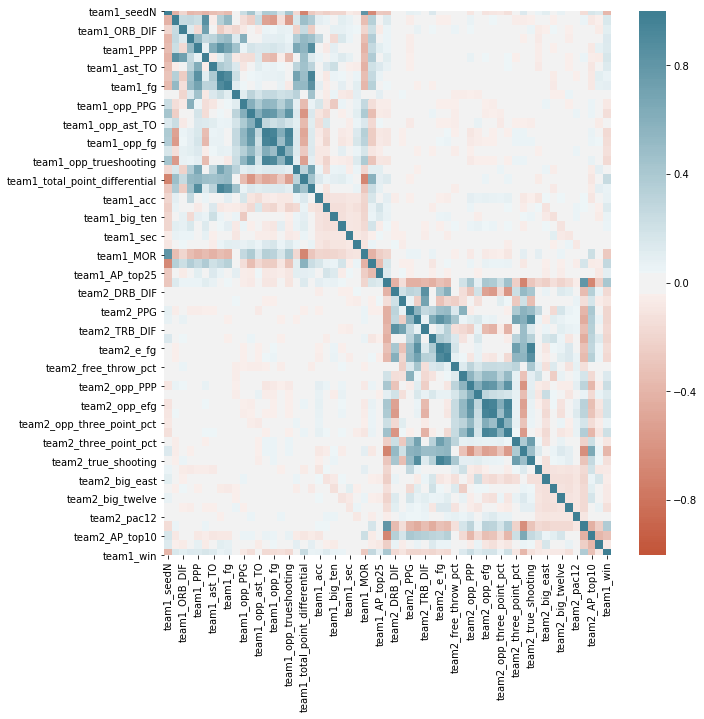

In [17]:
X_corr = X.corr()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(X_corr, cbar = True, vmin = -1, vmax= 1, center = 0,
            cmap=sns.diverging_palette(20, 220, n=200), ax = ax);

In [18]:
X_corr = X.corr().abs()
all_correlated = X_corr.where(np.triu(np.ones(X_corr.shape), k = 1).astype(np.bool)).\
stack().sort_values(ascending = False)

highly_correlated = all_correlated[all_correlated > 0.75]
highly_correlated

team2_e_fg     team2_true_shooting       0.954824
team2_opp_efg  team2_opp_trueshooting    0.951079
               team2_opp_fg              0.949879
team1_e_fg     team1_true_shooting       0.949395
team1_opp_efg  team1_opp_trueshooting    0.949353
               team1_opp_fg              0.948158
team2_opp_fg   team2_opp_trueshooting    0.906947
team1_opp_fg   team1_opp_trueshooting    0.906832
team2_e_fg     team2_fg                  0.899743
team1_e_fg     team1_fg                  0.883464
team1_PPP      team1_true_shooting       0.881044
team2_PPP      team2_true_shooting       0.877485
team2_fg       team2_true_shooting       0.856970
team1_DRB_DIF  team1_TRB_DIF             0.852304
team2_DRB_DIF  team2_TRB_DIF             0.842798
team1_PPP      team1_e_fg                0.841317
team2_PPP      team2_e_fg                0.841066
team1_fg       team1_true_shooting       0.838926
team2_opp_PPP  team2_opp_trueshooting    0.835596
               team2_opp_efg             0.830458


In [19]:
team_one_correlation = []
for i in all_correlated.index:
    if "team1_win" in i:
        team_one_correlation.append(i)

team_one_correlation = all_correlated[team_one_correlation]
team_one_correlation[:20]

team2_seedN                     team1_win    0.414510
team1_seedN                     team1_win    0.378406
team2_total_point_differential  team1_win    0.377016
team2_MOR                       team1_win    0.372733
team2_AP_top10                  team1_win    0.325432
team1_MOR                       team1_win    0.280732
team1_AP_top10                  team1_win    0.277475
team1_total_point_differential  team1_win    0.256637
team2_opp_PPP                   team1_win    0.241520
team2_opp_trueshooting          team1_win    0.216192
team2_PPG                       team1_win    0.200518
team2_ast_TO                    team1_win    0.198134
team2_PPP                       team1_win    0.196631
team2_opp_efg                   team1_win    0.184626
team2_opp_fg                    team1_win    0.180588
team2_fg                        team1_win    0.178654
team2_TRB_DIF                   team1_win    0.176958
team1_TRB_DIF                   team1_win    0.168629
team1_opp_trueshooting      

Clearly there is a lot going on here. I also now have an idea (at least linearly) of which features correlate strongly with the target. 

In [35]:
X.head()

,team1_seedN,team1_DRB_DIF,team1_ORB_DIF,team1_PPG,team1_PPP,team1_TRB_DIF,team1_ast_TO,team1_e_fg,team1_fg,team1_free_throw_pct,team1_opp_PPG,team1_opp_PPP,team1_opp_ast_TO,team1_opp_efg,team1_opp_fg,team1_opp_three_point_pct,team1_opp_trueshooting,team1_three_point_pct,team1_total_point_differential,team1_true_shooting,team1_acc,team1_big_east,team1_big_ten,team1_big_twelve,team1_sec,team1_pac12,team1_MOR,team1_AP_top10,team1_AP_top25,team2_seedN,team2_DRB_DIF,team2_ORB_DIF,team2_PPG,team2_PPP,team2_TRB_DIF,team2_ast_TO,team2_e_fg,team2_fg,team2_free_throw_pct,team2_opp_PPG,team2_opp_PPP,team2_opp_ast_TO,team2_opp_efg,team2_opp_fg,team2_opp_three_point_pct,team2_opp_trueshooting,team2_three_point_pct,team2_total_point_differential,team2_true_shooting,team2_acc,team2_big_east,team2_big_ten,team2_big_twelve,team2_sec,team2_pac12,team2_MOR,team2_AP_top10,team2_AP_top25,team1_win
0,16,10,-42,71.206897,0.866162,-32,0.804255,0.486339,0.429265,0.762768,78.448276,0.937078,1.236559,0.518382,0.455882,0.367110,0.553323,0.360153,-210,0.539424,0,0,0,0,0,0,277.0,0,0,16,58,37,72.800000,0.878704,95,0.932166,0.501206,0.447527,0.619952,70.833333,0.853660,0.960465,0.487307,0.424945,0.325180,0.515957,0.320721,59,0.538334,0,0,0,0,0,0,293.0,0,0,1
1,1,77,52,71.166667,0.930072,129,1.200565,0.512972,0.446934,0.707885,60.166667,0.799394,0.763990,0.446284,0.404747,0.326781,0.488641,0.393673,330,0.549827,0,0,0,1,0,0,6.0,1,0,3,134,-43,80.103448,0.929051,91,1.098734,0.512195,0.470067,0.693431,69.896552,0.799883,1.100239,0.443703,0.390075,0.306870,0.479169,0.330435,296,0.551677,0,1,0,0,0,0,21.0,0,1,0
2,10,59,-9,70.100000,0.884178,50,0.842767,0.521328,0.469835,0.662162,65.566667,0.822586,0.801688,0.481165,0.420247,0.333333,0.512977,0.344898,136,0.552990,0,0,0,0,1,0,44.0,0,0,3,134,-43,80.103448,0.929051,91,1.098734,0.512195,0.470067,0.693431,69.896552,0.799883,1.100239,0.443703,0.390075,0.306870,0.479169,0.330435,296,0.551677,0,1,0,0,0,0,21.0,0,1,0
3,6,88,-16,80.785714,0.929044,72,1.339241,0.517756,0.464487,0.703642,66.857143,0.759001,0.703704,0.432193,0.378538,0.312715,0.479165,0.397895,390,0.554477,1,0,0,0,0,0,9.0,0,1,7,125,42,67.225806,0.891803,167,0.935698,0.498737,0.450758,0.734694,60.967742,0.826801,0.781038,0.458013,0.400641,0.338374,0.512773,0.366265,194,0.552539,0,0,1,0,0,0,16.0,0,0,0
4,5,25,61,70.724138,0.969208,86,1.265574,0.522393,0.464491,0.741135,58.689655,0.825396,0.800000,0.479612,0.430481,0.339492,0.513566,0.359127,349,0.566212,0,0,1,0,0,0,15.0,0,1,1,134,54,77.531250,0.949992,188,1.151111,0.537988,0.487426,0.706767,64.093750,0.799199,0.652751,0.464146,0.412325,0.328014,0.502864,0.355932,430,0.573880,0,0,0,0,1,0,1.0,1,0,0


In [36]:
binary_features = ["team1_acc", "team1_big_east", "team1_big_twelve", "team1_sec", "team1_pac12",
                  "team1_AP_top10", "team1_AP_top25", "team2_acc", "team2_big_east", "team2_big_ten", 
                  "team2_big_twelve", "team2_sec", "team2_pac12", "team2_AP_top10", "team2_AP_top25",
                  "team1_win"]

#fit and save standard scaler on training data (will use later on validation data)
to_scale = X.drop(columns = binary_features)
ss = StandardScaler()
ss.fit(to_scale)

pickle.dump(ss, open("./models/standard_scaler.pk", "wb"))

#transform training data
to_scale_cols = list(to_scale.columns)
npX = ss.transform(to_scale)
scaled_X = pd.DataFrame(npX)
scaled_X.columns = to_scale_cols
scaled_X = pd.concat([scaled_X, X[binary_features]], axis = 1)
#save scaled training data
scaled_X.to_csv("./engineered_data/scaled_training_data.csv.gz", index = False, compression = "gzip")

In [76]:
xtrain = scaled_X.drop(columns = ["team1_win"])
y = scaled_X["team1_win"]

In [78]:
algorithms = {"RandomForestClassifier" : [RandomForestClassifier(), {"n_estimators" : 100, "max_depth" : 8}],
             "LGBMClassifier" : [LGBMClassifier(), {"max_depth" : 7, "num_leaves" : 49}],
             "XGBClassifier" : [XGBClassifier(), {"max_depth" : 8}]}

all_results = []
for key in algorithms:
    results_dict = {}
    results_dict["algorithm"] = key
    selector = FeatureSelector(xtrain, y, algorithm = algorithms[key][0], metric = "roc", 
                              params = algorithms[key][1])
    selector.recursive_selection()
    results_dict["best_eval"] = selector.best_eval
    results_dict["best_subset"] = list(selector.best_subset)
    all_results.append(results_dict)

In [81]:
from collections import Counter
features = []
for algo in all_results:
    features += algo["best_subset"]
    
count = Counter(features)
count.most_common()

[('team1_seedN', 3),
 ('team1_total_point_differential', 3),
 ('team2_TRB_DIF', 3),
 ('team2_total_point_differential', 3),
 ('team2_MOR', 3),
 ('team1_MOR', 2),
 ('team2_seedN', 2),
 ('team1_ast_TO', 2),
 ('team1_opp_PPP', 2),
 ('team1_opp_three_point_pct', 2),
 ('team1_true_shooting', 2),
 ('team2_PPG', 2),
 ('team2_free_throw_pct', 2),
 ('team2_opp_three_point_pct', 2),
 ('team1_PPG', 1),
 ('team2_opp_ast_TO', 1),
 ('team2_true_shooting', 1),
 ('team1_PPP', 1),
 ('team1_TRB_DIF', 1),
 ('team1_opp_PPG', 1),
 ('team1_opp_fg', 1),
 ('team1_three_point_pct', 1),
 ('team2_DRB_DIF', 1),
 ('team2_PPP', 1),
 ('team2_opp_PPG', 1),
 ('team2_three_point_pct', 1),
 ('team1_big_east', 1),
 ('team1_big_twelve', 1),
 ('team1_pac12', 1),
 ('team2_sec', 1),
 ('team2_AP_top10', 1)]

5 features were considered important by all three models. I will try these 11 features with our baseline model and see if there is improvement, and if there is we will move forward with parameter tuning with these 5 features.

In [88]:
top_5 = count.most_common()[:5]
top_features = [i[0] for i in top_5]

reduced_X = xtrain[top_features]

In [89]:
lr = LogisticRegression(max_iter = 1000, penalty = "l1", solver = "liblinear", C = 0.1)
baseline_cv = cross_val_score(lr, reduced_X, y, scoring = "roc_auc", cv = 10).mean()
print("Baseline cross-validation ROC-AUC Score: {}".format(baseline_cv))

Baseline cross-validation ROC-AUC Score: 0.802432610124918


There was slight improvement from the full feature set and we were able using only five features, which is fantastic for model complexity and also understanding of important metrics. Now, with these 5 features selected, I will begin parameter tuning.

# Logistic Regression
Logistic regression was chosen as the baseline linear performance model, and it's outperformed all three of the tree based models that were used in feature selection, so we will start with Logistic Regression.

For the first round of parameter tuning, I am going to stick with the L1 regularization and use parameters compatible with L1 regularization.

In [94]:
lr.get_params()

{'C': 0.1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [97]:
l1parameter_grid = {"C" : [0.01, 0.1, 1.0],
                 "solver" : ["liblinear", "saga"],
                 "fit_intercept" : [True, False]}

grid_search = GridSearchCV(LogisticRegression(penalty = "l1"), param_grid = l1parameter_grid, scoring = "roc_auc",
                          n_jobs = -1, cv = 10)
grid_search.fit(reduced_X, y)
print('Best score: {}'.format(grid_search.best_score_))
print()
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.8026298487836948

Best parameters: {'C': 0.1, 'fit_intercept': True, 'solver': 'saga'}


In [100]:
l2parameter_grid = {"C" : [0.01, 0.1, 1.0, 10],
                   "solver" : ["newton-cg", "lbfgs", "sag", "saga", "liblinear"],
                   "fit_intercept" : [True, False]}

grid_searchl2 = GridSearchCV(LogisticRegression(penalty = "l2"), param_grid = l2parameter_grid,
                            scoring = "roc_auc", n_jobs = -1, cv = 10)
grid_searchl2.fit(reduced_X, y)
print('Best score: {}'.format(grid_searchl2.best_score_))
print()
print('Best parameters: {}'.format(grid_searchl2.best_params_))

Best score: 0.8012491781722552

Best parameters: {'C': 0.01, 'fit_intercept': True, 'solver': 'newton-cg'}


In [104]:
elasticnet_grid = {"C" : [0.01, 0.1, 1.0, 10],
                  "fit_intercept" : [True, False],
                  "l1_ratio" : [0.1, 0.25, 0.5, 0.75]}

grid_searchEN = GridSearchCV(LogisticRegression(penalty = "elasticnet", solver = "saga"),
                            param_grid = elasticnet_grid, scoring = "roc_auc", n_jobs = -1, cv = 10)
grid_searchEN.fit(reduced_X, y)
print('Best score: {}'.format(grid_searchEN.best_score_))
print()
print('Best parameters: {}'.format(grid_searchEN.best_params_))

Best score: 0.8040762656147271

Best parameters: {'C': 0.01, 'fit_intercept': False, 'l1_ratio': 0.5}


With the best parameter set and feature set avaiable, now I will test the model on the held-out validation data.

In [110]:
lr = LogisticRegression(solver = "saga", penalty = "elasticnet", C = 0.01, fit_intercept = False,
                       l1_ratio = 0.5)

lr.fit(reduced_X, y)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=0.5, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [112]:
#peak at coefficients
lr.coef_

array([[-0.35932129,  0.01613482,  0.        , -0.26189463,  0.25310965]])

In [113]:
reduced_X.head()

,team1_seedN,team1_total_point_differential,team2_TRB_DIF,team2_total_point_differential,team2_MOR
0,1.947783,-3.569683,-0.126553,-1.628089,4.819039
1,-1.281501,0.267569,-0.164928,0.026985,-0.404494
2,0.656069,-1.110999,-0.164928,0.026985,-0.404494
3,-0.205073,0.693931,0.564205,-0.685325,-0.500515
4,-0.420359,0.402584,0.765676,0.962765,-0.788577


The LogisticRegression model is not using total rebound differential... good to know.

In [111]:
pickle.dump(lr, open("./models/log_reg_pre2015.pk", "wb"))

In [109]:
validation2015 = validation_data[validation_data.Season == 2015].reset_index(drop = True).\
drop(columns = ["Season", "DayNum", "team1_TeamID", "team1_Score", "team2_TeamID", 
                              "team2_Score"])

validation2015_target = validation2015["team1_win"]

In [116]:
ss = pickle.load(open("./models/standard_scaler.pk", "rb"))

#fit and save standard scaler on training data (will use later on validation data)
to_scale = validation2015.drop(columns = binary_features)
to_scale_cols = list(to_scale.columns)
npX = ss.transform(to_scale)

valid2015_scaled = pd.DataFrame(npX)
valid2015_scaled.columns = to_scale_cols
valid2015_scaled = pd.concat([valid2015_scaled, validation2015[binary_features]], axis = 1)
#save scaled training data
scaled_X.to_csv("./engineered_data/scaled_validation2015_data.csv.gz", index = False, compression = "gzip")

In [118]:
valid2015_target = valid2015_scaled["team1_win"]
valid2015_scaled = valid2015_scaled.drop(columns = ["team1_win"])

test2015 = valid2015_scaled[top_features]

In [121]:
_2015preds = lr.predict(test2015)
print("The accuracy on the validation set was {}".format(accuracy_score(valid2015_target, _2015preds)))
print()
print("The ROC area under the curve was {}".format(roc_auc_score(valid2015_target, _2015preds)))

The accuracy on the validation set was 0.7761194029850746

The ROC area under the curve was 0.7762923351158645
